<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/KOSMOS-2/Inference_with_KOSMOS_2_for_multimodal_grounding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Inference with KOSMOS-2 for multimodal grounding and referral

In this notebook, we'll perform inference with Microsoft's new impressive multimodal large language model (LLM) called [KOSMOS-2](https://huggingface.co/docs/transformers/main/en/model_doc/kosmos-2). KOSMOS-2 follows a decoder-only Transformer architecture (like any other LLM like ChatGPT), but is trained on interleaved text and images, where the text contains references to objects in the images in the form of bounding boxes expressed as text.

## Set-up environment

Let's start by installing 🤗 Transformers. We install from main here since the model is brand new at the time of writing.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git accelerate bitsandbytes

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Load model

Next, let's load the model along with its processor. We specify load_in_4bit=True to reduce the size of the weights to be able to load the model in Google Colab. This is all thanks to the magic of bitsandbytes' integration in the Transformers library (see this blog post for all info).

In [2]:
from transformers import AutoProcessor, AutoModelForVision2Seq

processor = AutoProcessor.from_pretrained("microsoft/kosmos-2-patch14-224")
model = AutoModelForVision2Seq.from_pretrained("microsoft/kosmos-2-patch14-224", load_in_4bit=True, device_map={"":0}

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Load image and prompt

Let's start by illustrating image grounding. We'll load an image and provide a text prompt for the model to complete. For image grounding, one can specify the special \<grounding> token (which was used during training). Refer to section 3.1 in the [paper](https://arxiv.org/abs/2306.14824) for details on how grounded image-text pairs are represented for the model.

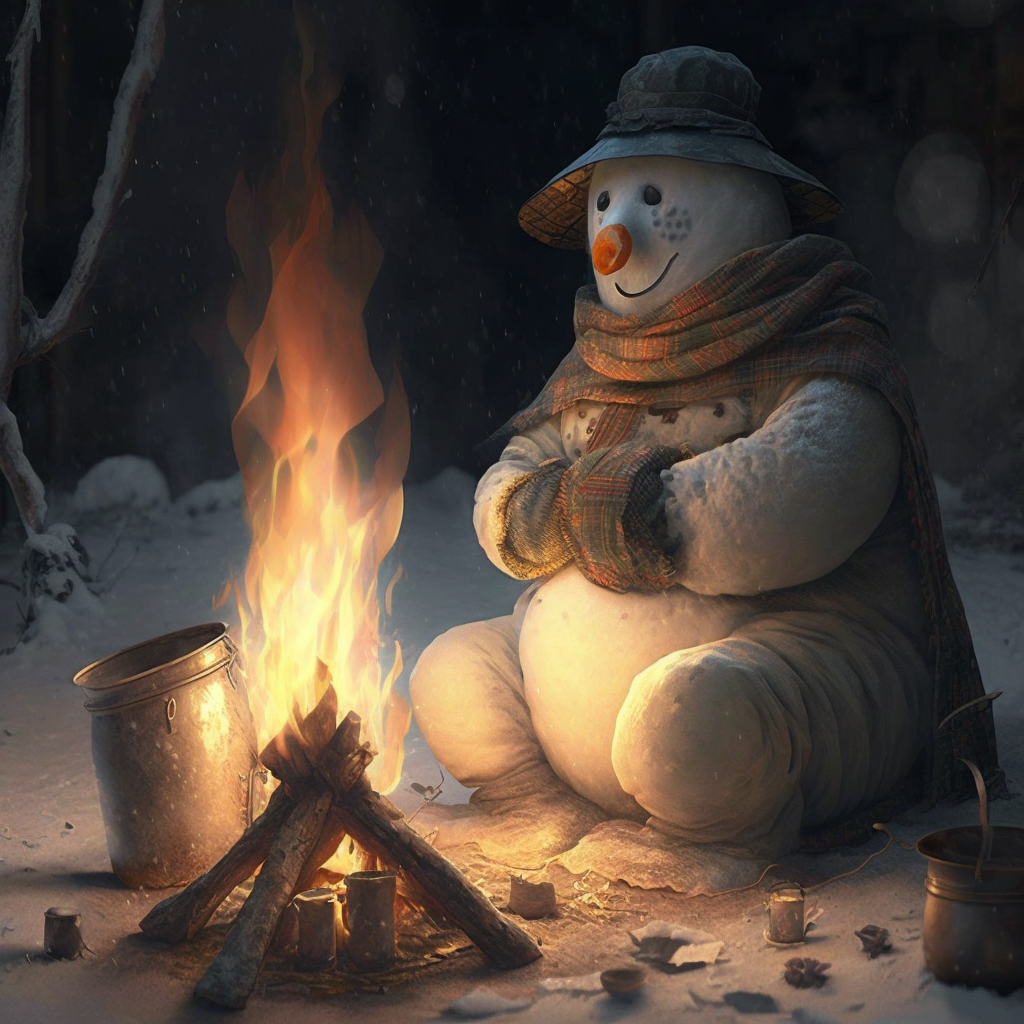

In [25]:
import requests
from PIL import Image

prompt = "<grounding>An image of"

url = "https://huggingface.co/microsoft/kosmos-2-patch14-224/resolve/main/snowman.png"
image = Image.open(requests.get(url, stream=True).raw)
image

## Generate completion

Next, we prepare the image and text prompt for the model using the processor, and then let the model autoregressively (which means, token by token) generate a completion.

In [4]:
inputs = processor(text=prompt, images=image, return_tensors="pt").to("cuda:0")

# autoregressively generate completion
generated_ids = model.generate(**inputs, max_new_tokens=128)
# convert generated token IDs back to strings
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:224: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_type=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(f'Input type into Linear4bit is torch.float16, but bnb_4bit_compute_type=torch.float32 (default). This will lead to slow inference or training speed.')


## Post processing

Let's look at the raw generated text:

In [11]:
print(generated_text)

<image>. the, to and of as in I that' for is was- on’ it with The as at bet he have from by are " you his “ this said not has an ( but had we her they will my or were their): up about out who one all been she can more would It</image><grounding> An image of<phrase> a snowman</phrase><object><patch_index_0044><patch_index_0863></object> warming up by<phrase> a fire</phrase><object><patch_index_0006><patch_index_0879></object>


As we can see, the first tokens don't make any sense. This is because those tokens correspond to the image patches (the model marks the start and end of these with special \<image> and \</image> tokens), which the model also gets as input. The model basically gets (start of image token, image patch token 1, image patch token 2, ..., end of image token, grounding token, ... text token 1, text token 2, ...) as input and is trained to predict the next text token.

We only need to take a look at the tokens after that:

In [15]:
end_of_image_token = processor.eoi_token
caption = generated_text.split(end_of_image_token)[-1]
print(caption)

<grounding> An image of<phrase> a snowman</phrase><object><patch_index_0044><patch_index_0863></object> warming up by<phrase> a fire</phrase><object><patch_index_0006><patch_index_0879></object>


As can be seen, the model complets the sentence by generating not only text tokens, but also special tokens like \<phrase> and \<object>, together with certain location tokens like \<patch_index_0044>.

This is exactly what the `post_process_generation` method provides as well in case you specify `cleanup_and_extract=False`:

In [16]:
# Specify `cleanup_and_extract=False` in order to see the raw model generation.
processed_text = processor.post_process_generation(generated_text, cleanup_and_extract=False)

print(processed_text)

<grounding> An image of<phrase> a snowman</phrase><object><patch_index_0044><patch_index_0863></object> warming up by<phrase> a fire</phrase><object><patch_index_0006><patch_index_0879></object>


Now, what do tokens like \<patch_index_0044> mean? Refer to the following section of the paper:

> The image resolution is set to 224×224 and the patch size is 14×14. We divide the width and height of the image into 32 bins, with each bin consisting of 7×7 pixels. A total of 32×32 location tokens are added to the vocabulary.

So basically, the model is able to spit out 32x32 possible location tokens to indicate where certain objects can be. Patch index 0044 is one of them.

To turn the raw location tokens into actual bounding boxes that can be plotted on an image, we can leverage the post_process_generation method, this time specifying to clean up and extract all entities:

In [17]:
# By default, the generated text is cleaned up and the entities are extracted.
processed_text, entities = processor.post_process_generation(generated_text)

print(processed_text)
print(entities)

An image of a snowman warming up by a fire
[('a snowman', (12, 21), [(0.390625, 0.046875, 0.984375, 0.828125)]), ('a fire', (36, 42), [(0.203125, 0.015625, 0.484375, 0.859375)])]


Let's plot the bounding boxes of the entities:

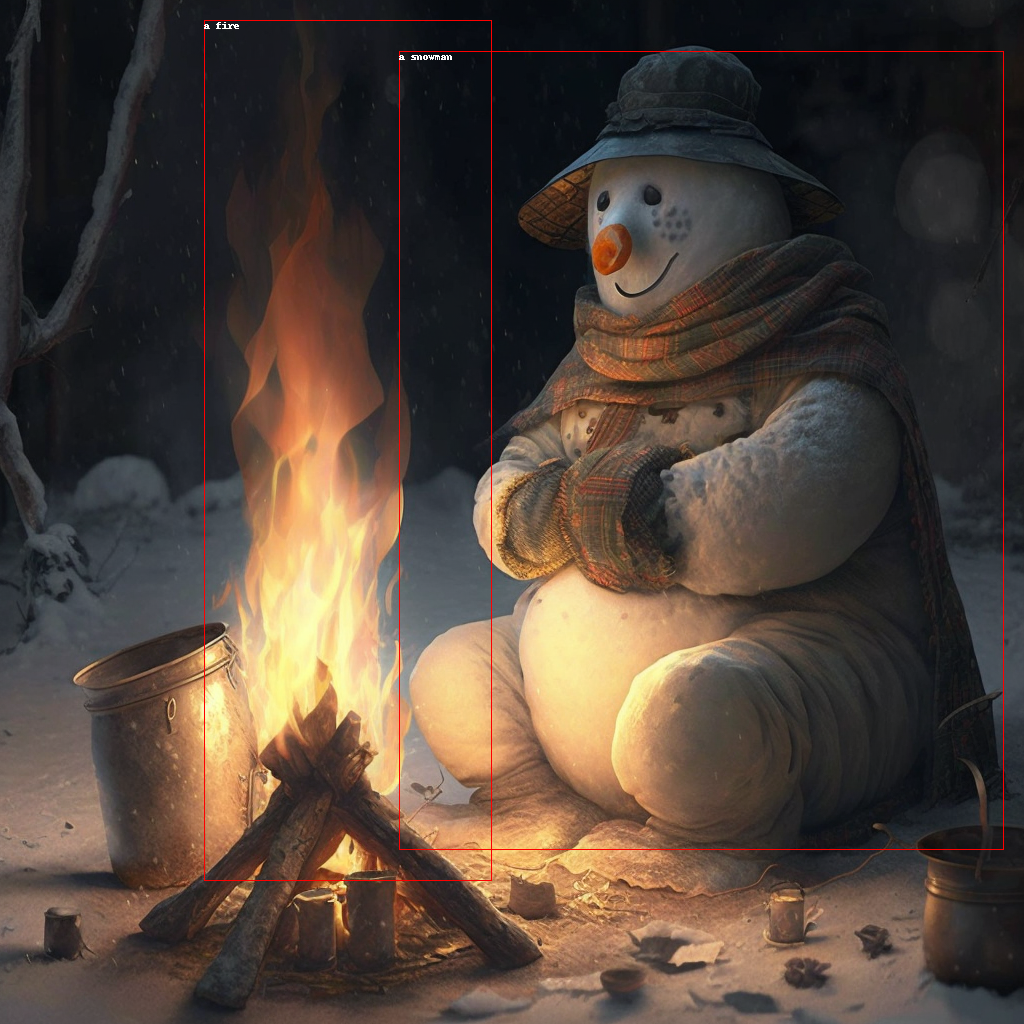

In [26]:
from PIL import ImageDraw

width, height = image.size

draw = ImageDraw.Draw(image)

for entity, _, box in entities:
    box = [round(i, 2) for i in box[0]]
    x1, y1, x2, y2 = tuple(box)
    x1, x2 = x1*width, x2*width
    y1, y2 = y1*height, y2*height
    draw.rectangle(xy=((x1, y1), (x2, y2)), outline="red")
    draw.text(xy=(x1, y1), text=entity)

image

Pretty great right? We can not only generate captions for images/answer questions, but also indicate where exactly objects are located.